In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm

import gymnasium as gym
import numpy as np
from collections import deque

# Initialize Cliff Walking environment
# 4x12 grid world with a start state, goal state, and cliff states
# Agent starts at start state(36) and must navigate to goal state (47) while avoiding cliff states (37-46)
# Agent receives a reward of -100 for falling off the cliff and -1 for each step taken
# Agent receives a reward of 0 for reaching the goal state and the episode ends
# Actions: 0 - up, 1 - right, 2 - down, 3 - left
# We have added a episode maximum of 1000 steps to prevent infinite loops
# Aim is to reach the goal state in the fewest steps possible

# Initialize environment; render_mode="human" for rendering the environment is shut off for training
env = gym.make("CliffWalking-v0")#,render_mode="human")

In [6]:
# Constants
DISCOUNT_FACTOR = 0.99
NUM_EPISODES = 100
MAX_STEPS = 1000
SOLVED_SCORE = -13  
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# Actor Network (Policy Network)
class ActorPolicy(nn.Module):
    def __init__(self, state_space, action_space):
        super(ActorPolicy, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, action_space)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

# Critic Network (State Value Network)
class CriticValue(nn.Module):
    def __init__(self, state_space):
        super(CriticValue, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
# Correctly initialize state from environment
state = env.reset()[0]

# Initialize networks.  Will generatea network of 48x128x4 for the actor and 48x128x1 for the critic
# 48 is the number of states in the environment; 4 is the number of states
actor_policy = ActorPolicy(env.observation_space.n, env.action_space.n).to(DEVICE) #
critic_value = CriticValue(env.observation_space.n).to(DEVICE)

# Initialize optimizers
# Adam optimizer is used for both the actor and critic
# The learning rate is set to 0.001 after trial and error using values from 0.0001 to 0.1
actor_optimizer = optim.Adam(actor_policy.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic_value.parameters(), lr=0.001)

In [9]:
# Track scores
scores = []
recent_scores = deque(maxlen=5)

# Training loop for number of defined episodes
for episode in tqdm(range(NUM_EPISODES)):
    state = env.reset()[0]
    score = 0

    while True:
        # Convert state to tensor for input into the networks
        state_tensor = torch.nn.functional.one_hot(torch.tensor(state), env.observation_space.n).float().to(DEVICE)
        
        # Agent selects action
        action_probs = actor_policy(state_tensor)
        # Categorical distribution is used to sample the action based on the probabilities
        m = Categorical(action_probs)
        action = m.sample()
                
        # Take action in the environment by using the step function defined in the gymnasium environment
        next_state, reward, done, _, _ = env.step(action.item())
        score += reward

        # Convert to tensors for updating state values
        next_state_tensor = torch.nn.functional.one_hot(torch.tensor(next_state), env.observation_space.n).float().to(DEVICE)
        reward_tensor = torch.tensor(reward, dtype=torch.float32).to(DEVICE)

        # Critic calculates value using the critic NN
        value = critic_value(state_tensor)
        next_value = critic_value(next_state_tensor) if not done else torch.tensor([0]).to(DEVICE)

        # Calculate TD error to be used in calculating the loss values
        td_target = reward_tensor + DISCOUNT_FACTOR * next_value
        td_error = td_target - value

        # Actor loss
        actor_loss = -m.log_prob(action) * td_error.detach()

        # Critic loss (MSE)
        critic_loss = F.mse_loss(value, td_target.detach())

        # Backpropagation
        actor_optimizer.zero_grad()
        critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        actor_optimizer.step()
        critic_optimizer.step()

        # this was added to end the loop if the episode gets too long or the agent goes off the cliff 10 times
        # we played with this value and found that 1000 was enough for the agent to learn the cliff is not the way to go
        # added print step to show why the episode ended
        if score < -MAX_STEPS:
            print("Score too low")
            break

        # Break if episode is done and print the state and next state, this will show the agent reached the terminal state (47)
        if done:
            print(state, next_state)
            break

        # Update state and continue
        state = next_state

    # Append episode score for graphing
    scores.append(score)
    recent_scores.append(score)

    # Early stopping if solved score goal is met
    if np.mean(recent_scores) >= SOLVED_SCORE:
        print(f"Environment solved in episode {episode}")
        break
env.close()


  1%|          | 1/100 [00:00<00:45,  2.19it/s]

Score too low


  2%|▏         | 2/100 [00:01<00:50,  1.94it/s]

Score too low


  3%|▎         | 3/100 [00:02<01:30,  1.07it/s]

Score too low


  4%|▍         | 4/100 [00:03<01:41,  1.06s/it]

Score too low


  5%|▌         | 5/100 [00:05<01:52,  1.19s/it]

35 47


  6%|▌         | 6/100 [00:06<01:58,  1.26s/it]

35 47


  7%|▋         | 7/100 [00:07<01:41,  1.09s/it]

35 47


  8%|▊         | 8/100 [00:08<01:30,  1.01it/s]

35 47
35 47


 11%|█         | 11/100 [00:08<00:41,  2.14it/s]

35 47
35 47


 12%|█▏        | 12/100 [00:09<00:50,  1.75it/s]

35 47


 15%|█▌        | 15/100 [00:09<00:25,  3.27it/s]

35 47
35 47
35 47
35 47


 19%|█▉        | 19/100 [00:09<00:13,  6.03it/s]

35 47
35 47
35 47


 23%|██▎       | 23/100 [00:10<00:08,  9.03it/s]

35 47
35 47
35 47
35 47


 25%|██▌       | 25/100 [00:10<00:06, 10.92it/s]

35 47
35 47
35 47
35 47


 29%|██▉       | 29/100 [00:10<00:05, 13.39it/s]

35 47
35 47
35 47
35 47
35 47


 35%|███▌      | 35/100 [00:10<00:03, 17.48it/s]

35 47
35 47
35 47
35 47


 39%|███▉      | 39/100 [00:11<00:03, 17.21it/s]

35 47
35 47
35 47
35 47
35 47


 45%|████▌     | 45/100 [00:11<00:02, 19.61it/s]

35 47
35 47
35 47
35 47
35 47


 48%|████▊     | 48/100 [00:11<00:02, 19.97it/s]

35 47
35 47
35 47
35 47
35 47


 54%|█████▍    | 54/100 [00:11<00:02, 21.41it/s]

35 47
35 47
35 47
35 47
35 47
35 47


 60%|██████    | 60/100 [00:12<00:01, 22.68it/s]

35 47
35 47
35 47
35 47
35 47


 66%|██████▌   | 66/100 [00:12<00:01, 20.47it/s]

35 47
35 47
35 47
35 47


 69%|██████▉   | 69/100 [00:12<00:01, 21.76it/s]

35 47
35 47
35 47
35 47
35 47


 75%|███████▌  | 75/100 [00:12<00:01, 21.49it/s]

35 47
35 47
35 47
35 47
35 47
35 47


 81%|████████  | 81/100 [00:13<00:00, 22.38it/s]

35 47
35 47
35 47
35 47
35 47


 87%|████████▋ | 87/100 [00:13<00:00, 22.34it/s]

35 47
35 47
35 47
35 47
35 47


 90%|█████████ | 90/100 [00:13<00:00, 22.74it/s]

35 47
35 47
35 47
35 47
35 47


 95%|█████████▌| 95/100 [00:13<00:00,  6.95it/s]

35 47
35 47
35 47
35 47
Environment solved in episode 95


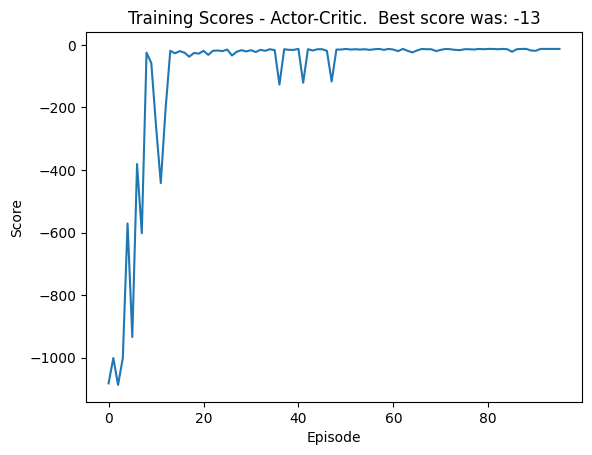

Total score: -13


In [16]:
# Plot scores
import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("Training Scores - Actor-Critic.  Best score was: " + str(np.max(scores)))
plt.show()
print("Total score:", score)

In [18]:
# Play Cliff Walking with trained model
# Initialize Cliff Walking environment
env = gym.make("CliffWalking-v0",render_mode="human")
state, _ = env.reset()
done = False
score = 0
while not done:
    state_tensor = torch.nn.functional.one_hot(torch.tensor(state), env.observation_space.n).float().to(DEVICE)
    action_probs = actor_policy(state_tensor)
    action = torch.argmax(action_probs).item()
    next_state, reward, done, _ = env.step(action)[:4]
    score += reward
    # this was added to end the loop if the episode gets too long or the agent goes off the cliff 10 times
    if score < -MAX_STEPS:
        print("Score too low")
        break
    state = next_state
    env.render()

env.close()
print("Total score:", score)

Total score: -13


: 